In [25]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import math
import localizer_functions # custom stuff
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../')
import functions

this function converts an opencv image to grayscale and runs the connectedComponents analyisis on it

### Parameters:

input:
src - an opencv image

output:
(num_labels, labels, stats, centroids) - returns what connectedComponents returns

In [26]:
def prepare_image(src):
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    thresh = cv2.bitwise_not(thresh)
    connectivity = 4  # You need to choose 4 or 8 for connectivity type
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh , connectivity , cv2.CV_32S, cv2.CCL_DEFAULT)
    return (num_labels, labels, stats, centroids)



this function splits the labels into division symbols and everything else

this is done by analyzing which labels are on top of each other and classifying three of those as a division symbol. The corresponding labels are removed from the digit_indices and an entry in division_symbol pairs is generated. 
a pair consists of (a, list), where a is the index of the line and list is a list of the indices of the three elements of a division symbol

In [27]:
""""""
def split_division_rest(num_labels, stats):
    overlaps = [(i - 1,[]) for i in range(1, num_labels)] # zero based
    for i in range(1, num_labels):
        left_i = stats[i, cv2.CC_STAT_LEFT]
        width_i = stats[i, cv2.CC_STAT_WIDTH]
        for j in range(1, num_labels):
            left_j = stats[j, cv2.CC_STAT_LEFT]
            # if left of j is within limits of i, add to the overlap list
            if left_j in range(left_i, left_i + width_i):
                _, l = overlaps[i - 1]
                l.append(j - 1)


    print(overlaps)
    # we only want to detect division, so we want a symbol with three overlaps
    # the symbol itself (the line) and the two dots
    division_symbols_pairs = list(filter(lambda x: len(x[1]) == 3, overlaps))
    print(division_symbols_pairs)
    digit_indices = np.arange(1, num_labels)
    # now filter all division symbols from our normal array, we will handle them later
    for e in division_symbols_pairs:
        i, list_of_division_operator = e
        print(list_of_division_operator)
        digit_indices = np.delete(digit_indices, list_of_division_operator)
    print(digit_indices)
    return (division_symbols_pairs, digit_indices)

this function extracts all the division symbols from the pairs using stats and the src image

In [28]:
def get_division_symbols(division_symbols_pairs, stats, src):
    division_symbols = []
    for pair in division_symbols_pairs:
        image = localizer_functions.extract_square_division_symbol(pair, stats, src)
        i, _ = pair
        division_symbols.append((i,image))
    return division_symbols
#division_symbols

now we are using all those images to do our analysis

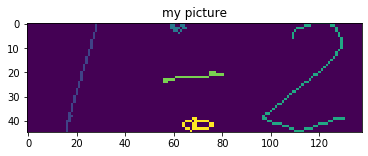

In [29]:
#src = cv2.imread('../images_no_copies/div/div_665.jpg')
src = cv2.imread('../generated_images/1div2/7.png')
num_labels, labels, stats, centroids = prepare_image(src)


plt.imshow(labels)
plt.title("my picture")
plt.show()

show the upper left corner of every detected component

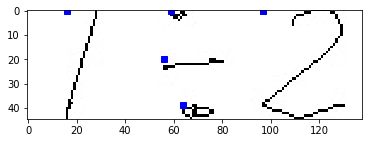

In [30]:
plt.imshow(src)
for i in range(1, num_labels):
    # get stats for i-th number by using stats[i, PROPERTY]
    left = stats[i, cv2.CC_STAT_LEFT]
    top = stats[i, cv2.CC_STAT_TOP]
    plt.plot(left, top, 'bs')
    #print(left, top)
plt.show()

overlaps is a list of tuples, with each tuple being (i, list) where the list is a list of digits which start within the x range of the i-th digit

In [31]:
division_symbols_pairs, digit_indices = split_division_rest(num_labels, stats)

[(0, [0]), (1, [1, 4]), (2, [2]), (3, [1, 3, 4]), (4, [4])]
[(3, [1, 3, 4])]
[1, 3, 4]
[1 3]


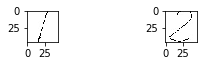

In [32]:
# print all digits
digits = []
for i in digit_indices:
    number = localizer_functions.extract_number(stats, src, i)
    squared = localizer_functions.make_square_out_of(number)
    digits.append(squared)
    num = plt.subplot(6,5,i)
    #cv2.imwrite(str(i) + "-sq.jpg", squared)
    num.imshow(squared)
plt.show()

In [33]:
div_sym = get_division_symbols(division_symbols_pairs, stats, src)
#print(div_sym[0][1])
all_symbols = digits + [div_sym[x][1] for x in range(0, len(div_sym))]
#all_symbols.append(digits)
#all_symbols.append(division_symbols)
print(len(all_symbols))
print(len(digits))
plt.show()

3
2


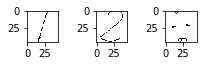

In [34]:
i = 1
for img in all_symbols:
    num = plt.subplot(6,5,i)
    i = i + 1
    
    cv2.imwrite( f"{i}.png", img)
    num.imshow(img)
plt.show()

In [35]:
equations = localizer_functions.get_all_data_cv('../generated_images')

def get_x_coord(img_pair):
    i, _ = img_pair
    return stats[i, cv2.CC_STAT_LEFT]

for equ_type in [equations[x] for x in equations]:
    #print(equ_type)
    for equ in equ_type:
        #print(equ)
        num_labels, labels, stats, centroids = prepare_image(equ)
        division_symbols_pairs, digit_indices = split_division_rest(num_labels, stats)
        # get the digits
        # print all digits
        digits = []
        for i in digit_indices:
            number = localizer_functions.extract_number(stats, equ, i)
            squared = localizer_functions.make_square_out_of(number)
            digits.append((i, squared))
        all_symbols = digits + get_division_symbols(division_symbols_pairs, stats, equ)
        sorted_symbols = sorted(all_symbols, key = get_x_coord)
        if all_symbols != sorted_symbols:
            break
        if len(all_symbols) != 3:
            print(len(all_symbols))
            break
    break



Test
[(0, [0]), (1, [1]), (2, [2])]
[]
[1 2 3]
[(0, [0]), (1, [1]), (2, [2])]
[]
[1 2 3]
[(0, [0]), (1, [1]), (2, [2])]
[]
[1 2 3]
[(0, [0]), (1, [1]), (2, [2])]
[]
[1 2 3]


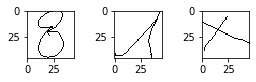

In [38]:
i = 1
for (_, img) in all_symbols:
    num = plt.subplot(4,4,i)
    cv2.imwrite( f"{i}.png", img)
    i = i + 1
    
    num.imshow(img)
plt.show()

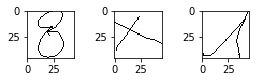

In [39]:
i = 1
for (_, img) in sorted_symbols:
    num = plt.subplot(4,4,i)
    cv2.imwrite( f"{i}.png", img)
    i = i + 1
    
    num.imshow(img)
plt.show()